# Summarization

Today we will work on a text summarization problem using Hugging Face. For such, we will use the `samsum` dataset of text conversations.

## SamSum

In [1]:
from datasets import load_dataset

dataset_samsum = load_dataset("knkarthick/samsum")

/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let us explore a little the dataset before actually preprocessing for training.    

In [2]:
splits = ['train', 'validation', 'test']
for split in splits:
    print('Size of', split, ':', dataset_samsum[split].num_rows)

Size of train : 14731
Size of validation : 818
Size of test : 819


We can look at some entries.

In [3]:
print('Dialogue:\n', dataset_samsum['train'][1234]['dialogue'])
print('---------------\nSummary:\n', dataset_samsum['train'][1234]['summary'])

Dialogue:
 Emily: I hope you're not planning to cut my body into pieces today. I can't really take a day off
Stuart: Haha, no something much more terrible!
Emily: what is much more terrible?
Stuart: dissecting your soul…
Emily: Jesus, are you going to spoil me with stories about good books and philosophy? I'm scared.
Stuart: You can expect an interview format ....
Emily: Oh, ok. I am a recruiter, so you shall better prepare.
---------------
Summary:
 Emily and Stuart are planning a meeting. Emily can't take a day off later.


Sizes are ok for fine-tuning, so we will follow the book and fine-tune Pegasus pretrained on CNN/Daily Mail. Let us see token distribution.

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail", use_fast=False)
tokenized_dialogues = list(map(tokenizer.encode, dataset_samsum[split]['dialogue']))
tokenized_summaries = list(map(tokenizer.encode, dataset_samsum[split]['summary']))

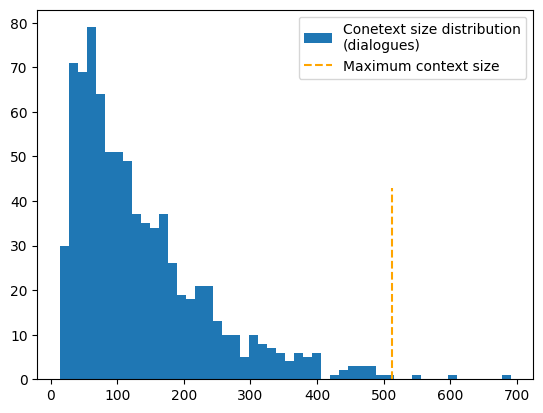

In [5]:
import matplotlib.pyplot as plt
plt.hist(list(map(len, tokenized_dialogues)), bins = 50, label = 'Conetext size distribution\n(dialogues)')
plt.vlines(512, 0, 43, colors = 'orange', linestyles = '--', label = 'Maximum context size')
plt.legend()
plt.show()

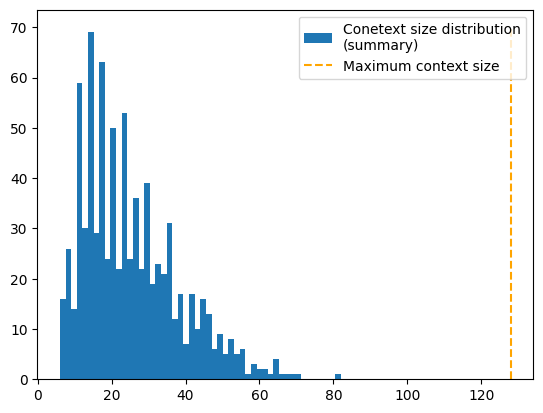

In [6]:
plt.hist(list(map(len, tokenized_summaries)), bins = 50, label = 'Conetext size distribution\n(summary)') 
# 128 is what the book uses for a max context size for summarization
plt.vlines(128, 0, 70, colors = 'orange', linestyles = '--', label = 'Maximum context size') 
plt.legend()
plt.show()

Let us see how many dialogues will be truncated by using Pegasus with maximum context size equal to 512.

In [7]:
longer = [i > 512 for i in list(map(len, tokenized_dialogues))]
print('Dialogues truncated:', sum(longer))
print('Percentage of truncated dialogues:', sum(longer)/len(longer))

Dialogues truncated: 3
Percentage of truncated dialogues: 0.003663003663003663


So very negligeble.

## Zero-shot

Let us see how well the model performs using zero-shot learing. 

In [8]:
import torch 
from transformers import AutoModelForSeq2SeqLM 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# We will use an extremely quantized version of the model here
# I will use a smaller distilled version
model = AutoModelForSeq2SeqLM.from_pretrained('google/pegasus-xsum').to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now, we willf ollow the book in making an evaluation function based on some custom metrics (we will use both BLEU and ROUGE here).

In [12]:
from tqdm import tqdm

def generate_batch(input_list, batch_size):
    '''
    Makes batches, which are important for model evaluation due to padding.
    '''
    for i in range(0, len(input_list), batch_size):
        yield input_list[i : i + batch_size]
    
def evaluate_model(dataset, metric, model, tokenizer,
                   batch_size = 16, device = device,
                   column_text = 'dialogue',
                   column_summary = 'summary'):
    
    dialogue_bateches =  list(generate_batch(dataset[column_text], batch_size))
    summary_batches =  list(generate_batch(dataset[column_summary], batch_size))

    for dialogue_batch, target_batch in tqdm(
        zip(dialogue_bateches, summary_batches), total = len(dialogue_bateches)
    ):
    # Total in tqdm gives the total number of iterations, so percentages can be computed
        inputs = tokenizer(dialogue_batch, max_length = 1024, truncation = True,
                           padding = 'max_length', return_tensors = 'pt')
        with torch.no_grad():
            summaries = model.generate(input_ids = inputs['input_ids'].to(device),
                                    attention_mask = inputs['attention_mask'].to(device),
                                    length_penalty = 0.8, num_beams = 8, max_length = 128)
            # Length penalty forces the summary to be short, num_bemas sets up beam search
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens = True, 
                                              clean_up_tokenization_spaces = True)
                                              for s in summaries]
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        metric.add_batch(predictions = decoded_summaries, references = target_batch)
    
    score = metric.compute()

    return score

Now let us check the models. As the book, we will only test it on a small part of the test dataset.

In [13]:
import evaluate

bleu_metric = evaluate.load('bleu')
rouge_metric = evaluate.load('rouge')

test_sampled = dataset_samsum["test"].shuffle(seed = 42).select(range(500))

In [21]:
score = evaluate_model(test_sampled, bleu_metric, 
                                   model, tokenizer, batch_size = 8)

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [05:48<00:00,  5.53s/it]


In [22]:
print(score)

{'bleu': 0.0003361982971970144, 'precisions': [0.01777702050320895, 0.00019112784541579862, 9.64859805870207e-05, 3.897040197969642e-05], 'brevity_penalty': 1.0, 'length_ratio': 4.784510869565217, 'translation_length': 52821, 'reference_length': 11040}


So BLEU was not so good, although one might argue that it is ROUGE that we really should care about for summarization tasks. That said, let us check ROUGE.

In [23]:
score = evaluate_model(test_sampled, rouge_metric, 
                                   model, tokenizer, batch_size = 8)
print(score)

100%|██████████| 63/63 [05:37<00:00,  5.35s/it]


{'rouge1': np.float64(0.02244002826617531), 'rouge2': np.float64(0.0002803625817127167), 'rougeL': np.float64(0.021992082396725322), 'rougeLsum': np.float64(0.02203215745931677)}


Still bad. Let us just check one application to have a feeling of what might be going wrong.

In [27]:
dialogue_batch = test_sampled[0]['dialogue']
inputs = tokenizer(dialogue_batch, max_length = 1024, truncation = True,
                        padding = 'max_length', return_tensors = 'pt')
with torch.no_grad():
    summaries = model.generate(input_ids = inputs['input_ids'].to(device),
                            attention_mask = inputs['attention_mask'].to(device),
                            length_penalty = 0.8, num_beams = 8, max_length = 128)
decoded_summaries = [tokenizer.decode(s, skip_special_tokens = True, 
                                              clean_up_tokenization_spaces = True)
                                              for s in summaries]
print('Dialogue:"\n', dialogue_batch)
print('---------------\nSummary:\n', decoded_summaries[0])

Dialogue:"
 Claire: <file_photo>
Kim: Looks delicious...
Linda: No way... Look what I'm cooking right now:
Linda: <file_photo>
Claire: hahahaha 
Kim: Curry dream team
Claire: Enjoy your dinner :*
---------------
Summary:
 Linda: Look what I'm cooking right now... Look what I'm cooking right now.


This indeed seems to be a domain specification problem: the original Pegasus model was trained in the summarization of news articles, which means that it does not understand what comprises a dialogue well. That is, we will need to fine-tune.

## Fine-tuning
Now, we will fine-tune the model. Again, we will follow the book in creating a function for automatically tokenization. Unfortunately, pegasus ws too heavy for my GPU, so we will use the much smaller T5.

In [2]:
# Reimported because I restarted the kernel to clear VRAM
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "t5-small" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [3]:
import numpy as np 

def tokenize(batch):
    # I will use a smaller context size
    input_encodings = tokenizer(batch["dialogue"], truncation=True, max_length = 256, padding="max_length")
    # Need text target here
    target_encodings = tokenizer(text_target = batch["summary"], truncation=True, max_length = 64, padding="max_length")
    
    return {
        "input_ids": input_encodings["input_ids"], 
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]
    }

In [4]:
import torch
dataset_samsum_pt = dataset_samsum.map(tokenize, 
                                       batched = True)
columns = ['input_ids', 'labels', 'attention_mask']
# By doing columns = columns, we make that, when calling __getitem__
# only variables in `columns` will be returned, the rest, will be ignored
# This ensure that the dataset has no strings, only floats
dataset_samsum_pt.set_format(type = 'torch', columns = columns)
# Raw dataset if not needed anymore
import gc
del dataset_samsum  
gc.collect()
torch.cuda.empty_cache()

Map: 100%|██████████| 818/818 [00:00<00:00, 9113.26 examples/s]


Now we train

In [6]:
from transformers import DataCollatorForSeq2Seq
# Setting padding to True allows for dynamic padding
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model = model,  padding = False, return_tensors = 'pt',  label_pad_token_id = -100)

model.gradient_checkpointing_enable()
model.config.use_cache = False


from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir = 't5-samsum', num_train_epochs = 1, warmup_steps = 500,
    per_device_train_batch_size = 1, per_device_eval_batch_size = 1,
    weight_decay = 0.01, logging_steps = 5000, push_to_hub = False,
    eval_strategy = 'no', save_steps = 1e6,
    gradient_accumulation_steps = 4,
    fp16 = True)
     

In [7]:
trainer = Trainer(model = model, args = training_args,
                  tokenizer = tokenizer, data_collator = seq2seq_data_collator,
                  train_dataset = dataset_samsum_pt["train"], 
                  eval_dataset = dataset_samsum_pt["validation"])

trainer.train()

  0%|          | 0/3682 [00:00<?, ?it/s]/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
100%|██████████| 3682/3682 [16:36<00:00,  3.70it/s]

{'train_runtime': 996.1208, 'train_samples_per_second': 14.788, 'train_steps_per_second': 3.696, 'train_loss': 1.4131808884437806, 'epoch': 1.0}


TrainOutput(global_step=3682, training_loss=1.4131808884437806, metrics={'train_runtime': 996.1208, 'train_samples_per_second': 14.788, 'train_steps_per_second': 3.696, 'total_flos': 996657026039808.0, 'train_loss': 1.4131808884437806, 'epoch': 0.9997963478378928})

Let us now check its performance.

In [13]:
import evaluate

bleu_metric = evaluate.load('bleu')
rouge_metric = evaluate.load('rouge')

In [18]:
score = evaluate_model(test_sampled, bleu_metric, 
                                   trainer.model, tokenizer, batch_size = 8)
print(score)

  0%|          | 0/63 [00:00<?, ?it/s]

/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 63/63 [11:05<00:00, 10.56s/it]

{'bleu': 0.0011660304472826052, 'precisions': [0.033750551202469385, 0.0007936234084400124, 0.0003862223938766195, 0.00017869268432150389], 'brevity_penalty': 1.0, 'length_ratio': 2.670380434782609, 'translation_length': 29481, 'reference_length': 11040}


In [19]:
score = evaluate_model(test_sampled, rouge_metric, 
                                   trainer.model, tokenizer, batch_size = 8)
print(score)

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [09:59<00:00,  9.51s/it]


{'rouge1': np.float64(0.029275822901582177), 'rouge2': np.float64(0.0004118291347207009), 'rougeL': np.float64(0.028406529337711088), 'rougeLsum': np.float64(0.028535693302620735)}


Not much better, but let us give a manual inspection

In [23]:

from transformers import pipeline
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="t5-samsum/checkpoint-3682")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])
     


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. He called her last time she was at the park together. He's very nice.


As one can see, thje model is not too good, but could honestly be much worse. But recall that 1. this is a much smaller model, 2. we trained for only one epoch, 3. we used very strong quantization and severely limitted token size.